In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from numba import njit, prange
from tqdm import tqdm

In [2]:
# network constants
num_nodes_arr = [80, 100, 120, 140, 180]
degree = 3
networks = [nx.to_numpy_array(nx.random_regular_graph(degree, num_nodes)) for num_nodes in num_nodes_arr]

# Basic Local Average and Information Exchange (LAIE) algorithm

In [3]:
@njit(parallel=True)
def LAIE(W: np.ndarray, x_0: np.ndarray, timesteps=100, runs=100, epsilon=0.01):
	num_nodes = W.shape[0]
	convergence_times = np.zeros(runs)
	x_history = np.zeros((runs, num_nodes, timesteps))

	for run in prange(runs):
		x_history[run, :, 0] = x_0[run]

		x_avg = np.mean(x_history[run, :, 0]) * np.ones(num_nodes)
		x_0_norm = np.linalg.norm(x_history[run, :, 0])

		distance_from_avg = np.zeros(timesteps)
		distance_from_avg[0] = np.linalg.norm(x_history[run, :, 0] - x_avg) / x_0_norm

		for t in range(1, timesteps):
			i = t % num_nodes
			x_history[run, :, t] = W[i] @ x_history[run, :, t - 1]
			distance_from_avg[t] = np.linalg.norm(x_history[run, :, t] - x_avg) / x_0_norm

		convergence_times[run] = np.where(distance_from_avg <= epsilon)[0][0]

	return x_history, convergence_times

In [4]:
@njit
def get_W(adjacency_matrix: np.ndarray) -> np.ndarray:
	'''
	Generate edge weights for LAIE given the adjacency matrix
	'''
	num_nodes = adjacency_matrix.shape[0]
	diagonal_matrix = np.diag(np.sum(adjacency_matrix, axis=0))
	laplacian = diagonal_matrix - adjacency_matrix
	adjacency_with_self = adjacency_matrix + np.eye(num_nodes)

	neighbors_with_self = []
	for i in range(num_nodes):
		neighbors_with_self.append(np.nonzero(adjacency_with_self[i])[0])

	neighbors = []
	for i in range(num_nodes):
		neighbors.append(np.nonzero(adjacency_matrix[i])[0])

	W = np.zeros((num_nodes, num_nodes, num_nodes))

	for i in range(num_nodes):
		for j in range(num_nodes):
			for k in range(num_nodes):
				if j not in neighbors_with_self[i] and k == j:
					W[i, j, k] = 1
				elif (j in neighbors_with_self[i] and k in neighbors_with_self[i]) or (i == j and j == k and i == k):
					W[i, j, k] = 1 / len(neighbors_with_self[i])
				else:
					W[i, j, k] = 0

	return W

0it [00:00, ?it/s]/tmp/ipykernel_48438/1738158102.py:18: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  x_history[run, :, t] = W[i] @ x_history[run, :, t - 1]
/tmp/ipykernel_48438/1738158102.py:18: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  x_history[run, :, t] = W[i] @ x_history[run, :, t - 1]
5it [00:26,  5.33s/it]


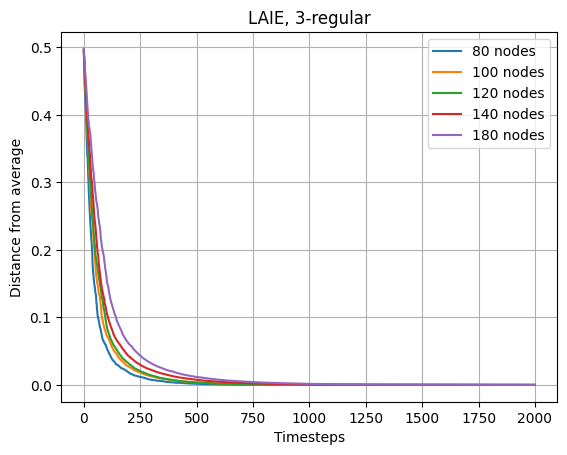

In [5]:
for networkIdx, adjacency_matrix in tqdm(enumerate(networks)):
	runs = 500
	num_nodes_in_network = adjacency_matrix.shape[0]

	# generate random initial states for each run
	initial_states = np.array([np.random.randint(0, 2, num_nodes_in_network) for _ in range(runs)])
	avg_states = np.mean(initial_states, axis=1)
	W = get_W(adjacency_matrix)

	x_history, _ = LAIE(W, initial_states, timesteps=2000, runs=runs, epsilon=0.01)

	# calculate the distance of each node from the average in every run,
	# then average over runs and nodes
	error_history = np.zeros_like(x_history)
	for run in range(runs):
		error_history[run] = np.abs(avg_states[run] - x_history[run])
	error_history = np.mean(error_history, axis=(0, 1)) # average over runs and nodes

	plt.plot(error_history, label=f'{num_nodes_in_network} nodes')
plt.xlabel('Timesteps')
plt.ylabel('Distance from average')
plt.grid()
plt.legend()
plt.title(f'LAIE, {degree}-regular')
plt.show()

# Multi Agent Multi Armed Bandit (MAMAB) simulation with LAIE

In [6]:
from lmsc import coopucb2
from graph_optimization import fastest_averaging_constant_weight

In [7]:
@njit(parallel=True)
def MAMAB_LAIE(W: np.ndarray, true_means: np.ndarray, timesteps=100, runs=100, epsilon=0.01):
	num_nodes = W.shape[0]
	num_arms = true_means[0].shape[0]
	sigma = 1

	regret_history = np.zeros((runs, num_nodes, timesteps))

	for run in prange(runs):
		cumulative_estimated_reward = np.zeros((num_nodes, num_arms))
		cumulative_estimated_pulls = np.zeros((num_nodes, num_arms))
		for t in range(timesteps):
			current_reward_vector = np.zeros((num_nodes, num_arms))
			current_pulls = np.zeros((num_nodes, num_arms))
			if t < num_arms:
				for k in range(num_nodes):
					action = t
					current_reward_vector[k, action] = np.random.normal(true_means[run, action], sigma)
					current_pulls[k, action] += 1
					regret_history[run, k, t] = np.abs(np.max(true_means[run]) - true_means[run, action])
			else:
				for k in range(num_nodes):
					# epsilon greedy
					action = np.random.randint(0, num_arms) if np.random.rand() < epsilon else np.argmax(cumulative_estimated_reward[k] / cumulative_estimated_pulls[k])
					current_reward_vector[k, action] = np.random.normal(true_means[run, action], sigma)
					current_pulls[k, action] += 1
					regret_history[run, k, t] = np.abs(np.max(true_means[run]) - true_means[run, action])

			# exchange information using LAIE algorithm
			for i in range(num_arms):
				for k in range(num_nodes):
					cumulative_estimated_reward[:, i] = W[k] @ (cumulative_estimated_reward[:, i] + current_reward_vector[:, i])
					cumulative_estimated_pulls[:, i] = W[k] @ (cumulative_estimated_pulls[:, i] + current_pulls[:, i])

	return regret_history

In [8]:
# mamab constants
runs = 100
timesteps = 200
num_arms = 100
true_means = np.array([np.random.normal(0, 1, num_arms) for _ in range(runs)])

num_nodes_arr = [80] # , 100, 120, 140, 180]
degree = 3
networks = [nx.to_numpy_array(nx.random_regular_graph(degree, num_nodes)) for num_nodes in num_nodes_arr]

running LAIE...
done.
running CoopUCB2...
done.


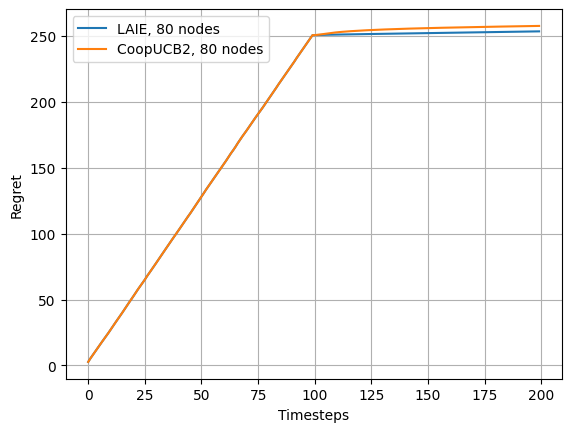

In [9]:
for networkIdx, adjacency_matrix in enumerate(networks):
	num_nodes_in_network = adjacency_matrix.shape[0]

	print('running LAIE...')
	W = get_W(adjacency_matrix)
	regret_history = MAMAB_LAIE(W, true_means, timesteps=timesteps, runs=runs, epsilon=0.01)
	regret_history = np.cumsum(regret_history, axis=2)
	regret = np.mean(regret_history, axis=(0, 1)) # average over runs and nodes
	plt.plot(regret, label=f'LAIE, {num_nodes_in_network} nodes')
	print('done.')

	print('running CoopUCB2...')
	_, _, best_constant_W, _ = fastest_averaging_constant_weight(np.asarray(nx.linalg.graphmatrix.incidence_matrix(nx.from_numpy_array(adjacency_matrix), oriented=True).todense()))
	coopucb2_regret = coopucb2(runs, num_arms, timesteps, true_means, best_constant_W)
	coopucb2_regret = np.cumsum(coopucb2_regret, axis=2)
	coopucb2_regret = np.mean(coopucb2_regret, axis=(0, 1)) # average over runs and nodes
	plt.plot(coopucb2_regret, label=f'CoopUCB2, {num_nodes_in_network} nodes')
	print('done.')

plt.xlabel('Timesteps')
plt.ylabel('Regret')
plt.grid()
plt.legend()
plt.show()